In [1]:
from sqlalchemy import create_engine, text
from sqlalchemy import text
import psycopg2
import psycopg2.extras
import json
import os
import pandas as pd
import requests
import ipywidgets as widgets
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

def display_image(response, w=200, h=300):
    return widgets.Image(value=response.content, format='jpg', width=w, height=h)

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

db, conn = pgconnect(credentials)

from sqlalchemy import text
conn.execute(text("set search_path to sa2project"))

Connected successfully.


In [2]:
conn.commit()
conn.execute(text("""
DROP TABLE IF EXISTS businesses CASCADE;
CREATE TABLE businesses(
   industry_code TEXT,
   industry_name TEXT,
   sa2_code TEXT,
   sa2_name TEXT,
   "0_to_50k_businesses" INTEGER NOT NULL,
   "50k_to_200k_businesses" integer NOT NULL,
   "200k_to_2m_businesses" integer NOT NULL,
   "2m_to_5m_businesses" integer NOT NULL,
   "5m_to_10m_businesses" integer NOT NULL,
   "10m_or_more_businesses" integer NOT NULL,
   total_businesses integer,
   PRIMARY KEY (sa2_code, industry_code),
   FOREIGN KEY (sa2_code) REFERENCES sa2project.sa2_boundaries(sa2_code21)
);"""))
businessdata = pd.read_csv('businesses.csv')
businessdata.columns = map(str.lower, businessdata.columns)
businessdata.to_sql("businesses", con=conn, if_exists='append', index=False)

217

In [3]:
conn.commit()
conn.execute(text("""
DROP TABLE IF EXISTS income CASCADE;
CREATE TABLE income(
    sa2_code21 text PRIMARY KEY,
    sa2_name text,
    earners integer,
    median_age integer,
    median_income integer,
    mean_income integer,
    FOREIGN KEY (sa2_code21) REFERENCES sa2project.sa2_boundaries(sa2_code21)
);"""))
incomedata = pd.read_csv('income.csv')
incomedata.columns = map(str.lower, incomedata.columns)
numeric_columns = ['earners', 'median_age', 'median_income', 'mean_income']
for col in numeric_columns:
    if col in incomedata.columns:
        incomedata[col] = pd.to_numeric(incomedata[col], errors='coerce')
incomedata.to_sql("income", con=conn, if_exists='append', index=False)

642

In [4]:
conn.commit()
conn.execute(text("""
DROP TABLE IF EXISTS population CASCADE;
CREATE TABLE population(
    sa2_code TEXT PRIMARY KEY,
    sa2_name text,
    "0-4_people" INTEGER,
    "5-9_people" INTEGER,
    "10-14_people" INTEGER,
    "15-19_people" INTEGER,
    "20-24_people" INTEGER,
    "25-29_people" INTEGER,
    "30-34_people" INTEGER,
    "35-39_people" INTEGER,
    "40-44_people" INTEGER,
    "45-49_people" INTEGER,
    "50-54_people" INTEGER,
    "55-59_people" INTEGER,
    "60-64_people" INTEGER,
    "65-69_people" INTEGER,
    "70-74_people" INTEGER,
    "75-79_people" INTEGER,
    "80-84_people" INTEGER,
    "85-and-over_people" INTEGER,
    "total_people" INTEGER,
    FOREIGN KEY (sa2_code) REFERENCES sa2project.sa2_boundaries(sa2_code21)
);"""))
populationdata = pd.read_csv('population.csv')
populationdata.columns = map(str.lower, populationdata.columns)
populationdata.to_sql("population", con=conn, if_exists='append', index=False)

373

In [5]:
import geopandas as gpd
from shapely.geometry import Point
from sqlalchemy import text
conn.execute(text("SET search_path TO sa2project, public")) # Ensure schema context
conn.commit()

create_stops_table_sql = """
DROP TABLE IF EXISTS STOPS CASCADE;
CREATE TABLE STOPS (
    stop_id VARCHAR(20) PRIMARY KEY,
    stop_code VARCHAR(20),
    stop_name TEXT,
    location_type integer,
    parent_station VARCHAR(20),
    wheelchair_boarding INTEGER,
    platform_code VARCHAR(20),
    geometry GEOMETRY(Point, 4326)
);
"""
try:
    conn.execute(text(create_stops_table_sql))
    conn.commit()

    # Load data using pandas and geopandas
    print("Reading Stops.txt...")
    stops_df = pd.read_csv("Stops.txt")
    stops_df.columns = map(str.lower, stops_df.columns) 
    stops_df = stops_df.replace({np.nan: None, "": None})
    stops_df['stop_lat'] = pd.to_numeric(stops_df['stop_lat'], errors='coerce')
    stops_df['stop_lon'] = pd.to_numeric(stops_df['stop_lon'], errors='coerce')

    original_count = len(stops_df)
    stops_df.dropna(subset=['stop_lat', 'stop_lon'], inplace=True)
    if len(stops_df) < original_count:
        print(f"Warning: Dropped {original_count - len(stops_df)} rows due to missing lat/lon.")

    print("Creating GeoDataFrame...")
    stops_gdf = gpd.GeoDataFrame(
        stops_df,
        geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat),
        crs="EPSG:4326" 
    )
    stops_gdf = stops_gdf.drop(columns=['stop_lat', 'stop_lon'])

    int_cols = ['wheelchair_boarding', 'location_type']
    for col in int_cols:
         if col in stops_gdf.columns:
            stops_gdf[col] = pd.to_numeric(stops_gdf[col], errors='coerce').astype('Int64')

    print("Writing STOPS data to PostGIS...")
    stops_gdf.to_postgis(
        name='stops',       # Table name (lowercase recommended)
        con=conn,           # Database connection engine
        schema='sa2project',# Target schema
        if_exists='append', # Append data to the existing (now empty) table
        index=False         # Don't write the DataFrame index
    )
    conn.commit() 
    index_sql = "CREATE INDEX idx_stops_geom ON stops USING gist(geometry);"
    conn.execute(text(index_sql))
    conn.commit()

except FileNotFoundError:
    print("ERROR: Stops.txt not found. Please check the path.")
except Exception as e:
    conn.rollback() # Rollback on error
    print(f"An error occurred during STOPS table processing: {e}") 

Reading Stops.txt...
Creating GeoDataFrame...
Writing STOPS data to PostGIS...


In [6]:
try:
    conn.execute(text("SET search_path TO sa2project, public")) 
    
    print("Attempting to drop sa2project.sa2_boundaries with CASCADE...")
    conn.execute(text("DROP TABLE IF EXISTS sa2project.sa2_boundaries CASCADE;"))
    conn.commit()
    print("Successfully dropped sa2project.sa2_boundaries with CASCADE (if it existed).")
    # --- END OF ADDED SECTION ---

    sa2_gdf = gpd.read_file('SA2/SA2_2021_AUST_GDA2020.shp')
    sa2_gdf.columns = map(str.lower, sa2_gdf.columns)

    if 'geometry' not in sa2_gdf.columns and 'geom' in sa2_gdf.columns:
         sa2_gdf = sa2_gdf.rename(columns={'geom': 'geometry'})
    elif 'geometry' not in sa2_gdf.columns:
         print("ERROR: Geometry column not found in SA2 shapefile.")
         raise ValueError("Geometry column not found in SA2 shapefile.")
    sa2_gdf.to_postgis(
        name='sa2_boundaries',
        con=conn,
        schema='sa2project',
        if_exists='replace', # This will now succeed as dependencies are removed by the CASCADE drop
        index=False
    )
    conn.commit()
    print("Successfully wrote SA2 boundaries to PostGIS table 'sa2project.sa2_boundaries'.")


    pk_column_name = 'sa2_code21' 

    if pk_column_name not in sa2_gdf.columns:
        print(f"ERROR: Primary key column '{pk_column_name}' not found in SA2 GeoDataFrame columns: {list(sa2_gdf.columns)}")

    else:
        conn.execute(text(f"ALTER TABLE sa2project.sa2_boundaries ALTER COLUMN {pk_column_name} SET NOT NULL;"))
        conn.commit()
        conn.execute(text(f"ALTER TABLE sa2project.sa2_boundaries ADD CONSTRAINT sa2_boundaries_pkey PRIMARY KEY ({pk_column_name});"))
        conn.commit()
        print(f"Successfully added PRIMARY KEY to sa2project.sa2_boundaries on {pk_column_name}.")

except FileNotFoundError:
    print("ERROR: SA2 shapefile not found. Please check the path 'SA2/SA2_2021_AUST_GDA2020.shp'.")
except Exception as e:
    conn.rollback() # Good practice to rollback on any error
    print(f"An error occurred during SA2 shapefile loading: {e}")


Attempting to drop sa2project.sa2_boundaries with CASCADE...
Successfully dropped sa2project.sa2_boundaries with CASCADE (if it existed).
Successfully wrote SA2 boundaries to PostGIS table 'sa2project.sa2_boundaries'.
Successfully added PRIMARY KEY to sa2project.sa2_boundaries on sa2_code21.


c

In [8]:
sa4data = gpd.read_file("sa4/SA4_2021_AUST_GDA2020.dbf")
pd.set_option('display.max_rows', None)
filtered = sa4data[sa4data["GCC_NAME21"] == "Greater Sydney"] 
filtered

,SA4_CODE21,SA4_NAME21,CHG_FLAG21,CHG_LBL21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
1,102,Central Coast,0,No change,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,1681.0088,http://linked.data.gov.au/dataset/asgsed3/SA4/102,"MULTIPOLYGON (((151.31497 -33.55578, 151.31496..."
14,115,Sydney - Baulkham Hills and Hawkesbury,0,No change,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,3251.4981,http://linked.data.gov.au/dataset/asgsed3/SA4/115,"MULTIPOLYGON (((151.15205 -33.52766, 151.15205..."
15,116,Sydney - Blacktown,0,No change,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,240.8835,http://linked.data.gov.au/dataset/asgsed3/SA4/116,"POLYGON ((150.87089 -33.82385, 150.87078 -33.8..."
16,117,Sydney - City and Inner South,0,No change,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,66.1035,http://linked.data.gov.au/dataset/asgsed3/SA4/117,"MULTIPOLYGON (((151.19474 -33.85326, 151.19501..."
17,118,Sydney - Eastern Suburbs,0,No change,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,57.7342,http://linked.data.gov.au/dataset/asgsed3/SA4/118,"MULTIPOLYGON (((151.26545 -33.9263, 151.26533 ..."
18,119,Sydney - Inner South West,0,No change,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,163.9272,http://linked.data.gov.au/dataset/asgsed3/SA4/119,"POLYGON ((151.09654 -33.99094, 151.09654 -33.9..."
19,120,Sydney - Inner West,0,No change,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,64.5491,http://linked.data.gov.au/dataset/asgsed3/SA4/120,"MULTIPOLYGON (((151.17407 -33.84586, 151.17377..."
20,121,Sydney - North Sydney and Hornsby,0,No change,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,275.0994,http://linked.data.gov.au/dataset/asgsed3/SA4/121,"MULTIPOLYGON (((151.17864 -33.5155, 151.17861 ..."
21,122,Sydney - Northern Beaches,0,No change,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,254.2072,http://linked.data.gov.au/dataset/asgsed3/SA4/122,"MULTIPOLYGON (((151.32886 -33.66075, 151.32885..."
22,123,Sydney - Outer South West,0,No change,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,1277.2421,http://linked.data.gov.au/dataset/asgsed3/SA4/123,"POLYGON ((150.82039 -33.97522, 150.8204 -33.97..."


In [9]:
def poi_in_bounding_box(xmin, ymin, xmax, ymax, filters={}):
    baseURL = 'https://maps.six.nsw.gov.au/arcgis/rest/services/public/NSW_POI/MapServer/0/query'
    params = {
        'geometry': f'{xmin},{ymin},{xmax},{ymax}',
        'geometryType': 'esriGeometryEnvelope',
        'inSR': '4326',
        'spatialRel': 'esriSpatialRelIntersects',
        'outFields': '*',
        'returnGeometry': 'true',
        'f': 'json',
        'where': ' AND '.join([f"{k}='{v}'" for k, v in filters.items()]) if filters else '1=1'
    }
    response = requests.get(baseURL, params=params)
    return json.loads(response.text)['features']

In [10]:
import time

sa2 = gpd.read_file('SA2/SA2_2021_AUST_GDA2020.shp')
sa2.columns = map(str.lower, sa2.columns) # <<< ADD THIS LINE TO CONVERT ALL COLUMNS TO LOWERCASE

# Now, access columns using their lowercase names
# For example, if the original shapefile had 'SA4_NAME21', it's now 'sa4_name21'
# And if it had 'SA2_NAME21', it's now 'sa2_name21'
# And if it had 'SA2_CODE21', it's now 'sa2_code21'

selected_sa4 = 'Sydney - Blacktown'
# Ensure you use the correct lowercase key for filtering by SA4 name
# If original was 'SA4_NAME21', use 'sa4_name21'
sa2_in_sa4 = sa2[sa2['sa4_name21'] == selected_sa4] # Adjust 'sa4_name21' if original was different

pois = []
for idx, row in sa2_in_sa4.iterrows():
    xmin, ymin, xmax, ymax = row['geometry'].bounds  
    poi_results = poi_in_bounding_box(xmin, ymin, xmax, ymax)

    for poi_feature in poi_results:
        # Use the lowercase column names from 'row'
        poi_feature['sa2_name21'] = row['sa2_name21'] # Use lowercase for SA2 name
        poi_feature['sa2_code21'] = row['sa2_code21'] # This should now work
        pois.append(poi_feature)
    time.sleep(1)
shopping_centres_found_in_api_data = []
for poi_feature in pois:
    if poi_feature.get('attributes', {}).get('poitype') == 'Shopping Centre':
        shopping_centres_found_in_api_data.append(poi_feature)
print(f"Found {len(shopping_centres_found_in_api_data)} 'Shopping Centre' POIs in raw API data for Sydney - Blacktown.")
print(shopping_centres_found_in_api_data)

Found 29 'Shopping Centre' POIs in raw API data for Sydney - Blacktown.
[{'attributes': {'objectid': 24221, 'topoid': 504301523, 'poigroup': 1, 'poitype': 'Shopping Centre', 'poiname': 'LEICESTER SQUARE', 'poilabel': 'LEICESTER SQUARE', 'poilabeltype': 'NAMED', 'poialtlabel': None, 'poisourcefeatureoid': 25, 'accesscontrol': 1, 'startdate': 1285588392000, 'enddate': 32503680000000, 'lastupdate': 1285588392535, 'msoid': 67973, 'centroidid': None, 'shapeuuid': '82b779b7-5d71-373b-af08-6fa4b20eb68b', 'changetype': 'I', 'processstate': None, 'urbanity': 'U'}, 'geometry': {'x': 150.8943759111678, 'y': -33.77790816901584}, 'sa2_name21': 'Blacktown (East) - Kings Park', 'sa2_code21': '116011303'}, {'attributes': {'objectid': 27632, 'topoid': 504443813, 'poigroup': 1, 'poitype': 'Shopping Centre', 'poiname': 'WESTPOINT CENTRE', 'poilabel': 'WESTPOINT CENTRE', 'poilabeltype': 'NAMED', 'poialtlabel': None, 'poisourcefeatureoid': 25, 'accesscontrol': 1, 'startdate': 1285588392000, 'enddate': 3250

In [11]:
# --- This code should be in cell 4e8f9b042c49d56f ---
conn.commit() # Commit any previous transactions

# Define the SQL for creating the table
# This includes the 'geometry' column of type GEOMETRY(Point, 4326)
# and the foreign key 'sa2_code21'
create_table_query = """
DROP TABLE IF EXISTS sa2project.PointsOfInterest CASCADE;
CREATE TABLE sa2project.PointsOfInterest (
    objectid BIGINT PRIMARY KEY,
    topoid BIGINT,
    poigroup INT,
    poitype TEXT,
    poiname TEXT,
    poilabel TEXT,
    poilabeltype TEXT,
    poialtlabel TEXT,
    poisourcefeatureoid BIGINT,
    accesscontrol TEXT,
    startdate BIGINT,
    enddate BIGINT,
    lastupdate BIGINT,
    msoid BIGINT,
    centroidid BIGINT,
    shapeuuid TEXT,
    changetype TEXT,
    processstate TEXT,
    urbanity TEXT,
    x FLOAT,
    y FLOAT,
    sa2_name21 TEXT,
    sa2_code21 TEXT,
    geometry GEOMETRY(Point, 4326),
    FOREIGN KEY (sa2_code21) REFERENCES sa2project.sa2_boundaries(sa2_code21)
);
"""
conn.execute(text(create_table_query))
conn.commit() # Commit the table creation
print("Table 'PointsOfInterest' created successfully with geometry column and foreign key.")

# Define the SQL for inserting data, including creating the Point geometry
# Note: ST_SetSRID(ST_MakePoint(:x, :y), 4326) creates the geometry
insert_query = """
INSERT INTO sa2project.PointsOfInterest (
    objectid, topoid, poigroup, poitype, poiname, poilabel, poilabeltype, poialtlabel,
    poisourcefeatureoid, accesscontrol, startdate, enddate, lastupdate,
    msoid, centroidid, shapeuuid, changetype, processstate, urbanity,
    x, y, sa2_name21, sa2_code21, geometry
) VALUES (
    :objectid, :topoid, :poigroup, :poitype, :poiname, :poilabel, :poilabeltype, :poialtlabel,
    :poisourcefeatureoid, :accesscontrol, :startdate, :enddate, :lastupdate,
    :msoid, :centroidid, :shapeuuid, :changetype, :processstate, :urbanity,
    :x, :y, :SA2_NAME21, :sa2_code21, ST_SetSRID(ST_MakePoint(:x, :y), 4326)
) ON CONFLICT (objectid) DO NOTHING;
"""

# Insert data (assuming 'pois' is the list of POI dictionaries from the previous cell)
print(f"Attempting to insert {len(pois)} POIs into the table...")
successful_inserts = 0
failed_inserts = 0

for poi_item in pois: # Use 'poi_item' to iterate through the list
    attributes = poi_item.get('attributes', {})
    # Get the nested geometry dictionary from the current poi_item
    # This is where 'x' and 'y' coordinates are stored from the API response
    poi_geometry_details = poi_item.get('geometry', {})

    # Prepare all data for insertion. Ensure keys here match the bind parameters in 'insert_query'
    data_to_insert = {
        'objectid': attributes.get('objectid'),
        'topoid': attributes.get('topoid'),
        'poigroup': attributes.get('poigroup'),
        'poitype': attributes.get('poitype'),
        'poiname': attributes.get('poiname'),
        'poilabel': attributes.get('poilabel'),
        'poilabeltype': attributes.get('poilabeltype'),
        'poialtlabel': attributes.get('poialtlabel'),
        'poisourcefeatureoid': attributes.get('poisourcefeatureoid'),
        'accesscontrol': attributes.get('accesscontrol'),
        'startdate': attributes.get('startdate'),
        'enddate': attributes.get('enddate'),
        'lastupdate': attributes.get('lastupdate'),
        'msoid': attributes.get('msoid'),
        'centroidid': attributes.get('centroidid'),
        'shapeuuid': attributes.get('shapeuuid'),
        'changetype': attributes.get('changetype'),
        'processstate': attributes.get('processstate'),
        'urbanity': attributes.get('urbanity'),
        'x': poi_geometry_details.get('x'), # Use 'poi_geometry_details' here
        'y': poi_geometry_details.get('y'), # And here
        'SA2_NAME21': poi_item.get('sa2_name21'), # This was added in the API fetching loop
        'sa2_code21': poi_item.get('sa2_code21')  # This was also added in the API fetching loop
    }

    # Ensure x and y are not None before trying to insert, as ST_MakePoint will fail with NULLs
    if data_to_insert['x'] is not None and data_to_insert['y'] is not None:
        try:
            conn.execute(text(insert_query), data_to_insert)
            successful_inserts += 1
        except Exception as e:
            failed_inserts += 1
            print(f"Error inserting POI with objectid {attributes.get('objectid')}: {e}")
            # print(f"Data was: {data_to_insert}") # Uncomment for more detailed debugging if needed
    else:
        failed_inserts += 1
        # print(f"Skipping POI with objectid {attributes.get('objectid')} due to missing coordinates.")

conn.commit() # Commit all successful inserts
print(f"POI data insertion complete. Successful: {successful_inserts}, Failed/Skipped: {failed_inserts}")

# Create a spatial index on the new geometry column for better query performance
try:
    conn.execute(text("CREATE INDEX IF NOT EXISTS idx_pointsofinterest_geom ON sa2project.pointsofinterest USING gist(geometry);"))
    conn.commit()
    print("Spatial index on PointsOfInterest.geometry ensured.")
except Exception as e:
    conn.rollback()
    print(f"Error creating spatial index on POI geometry: {e}")

Table 'PointsOfInterest' created successfully with geometry column and foreign key.
Attempting to insert 2747 POIs into the table...
POI data insertion complete. Successful: 2747, Failed/Skipped: 0
Spatial index on PointsOfInterest.geometry ensured.


In [12]:
conn.execute(text("SET search_path TO sa2project, public"))
conn.commit()

In [13]:
import geopandas as gpd
import pandas as pd
from sqlalchemy import text
import os

catchment_dir = 'Catchments/catchments/'

# List the expected shapefiles - ADJUST FILENAMES if they are different!
catchment_files = {
    'Primary': os.path.join(catchment_dir, 'catchments_primary.shp'),
    'Secondary': os.path.join(catchment_dir, 'catchments_secondary.shp'),
    'Future': os.path.join(catchment_dir, 'catchments_future.shp') # Adjust if filename differs
}

all_catchments_list = [] # To store individual GeoDataFrames
base_crs = None # To store the CRS of the first file read

print("Loading and combining school catchment shapefiles...")

# Loop through the defined files
for catchment_type, file_path in catchment_files.items():
    if not os.path.exists(file_path):
        print(f"Warning: Shapefile not found at {file_path}. Skipping.")
        continue
    try:
        gdf = gpd.read_file(file_path)

        gdf['catchment_type'] = catchment_type

        if gdf.crs is None:
            print(f"Warning: CRS not set for {file_path}. Assuming GDA2020 (EPSG:7844). Set explicitly if different.")
            gdf.set_crs(epsg=7844, inplace=True) # Adjust EPSG if needed (e.g., 4283 for GDA94)

        if base_crs is None:
            base_crs = gdf.crs # Set the CRS from the first file
            print(f"Detected base CRS: {base_crs}")
        elif gdf.crs != base_crs:
            print(f"Warning: CRS mismatch for {file_path} ({gdf.crs}). Transforming to base CRS ({base_crs}).")
            gdf = gdf.to_crs(base_crs)
        # -----------------------------------------------------

        all_catchments_list.append(gdf)
        print(f"Successfully read {len(gdf)} features from {file_path}")

    except Exception as e:
        print(f"ERROR: Could not read or process {file_path}. Error: {e}")



Loading and combining school catchment shapefiles...
Detected base CRS: EPSG:4283
Successfully read 1662 features from Catchments/catchments/catchments_primary.shp
Successfully read 436 features from Catchments/catchments/catchments_secondary.shp
Successfully read 30 features from Catchments/catchments/catchments_future.shp


In [14]:
# This code should come after Cell 13 where 'all_catchments_list' and 'base_crs' are defined.

if all_catchments_list:
    print("Combining all school catchment GeoDataFrames...")
    # Concatenate all GeoDataFrames in the list into a single GeoDataFrame
    combined_catchments_gdf = gpd.GeoDataFrame(pd.concat(all_catchments_list, ignore_index=True), crs=base_crs)
    
    # Standardize column names to lower case for consistency, if not already done
    combined_catchments_gdf.columns = map(str.lower, combined_catchments_gdf.columns)
    

    print(f"Combined GeoDataFrame has {len(combined_catchments_gdf)} features.")
    print(f"CRS of combined GeoDataFrame: {combined_catchments_gdf.crs}")

    table_name = 'schoolcatchments'
    schema_name = 'sa2project'

    try:
        conn.commit() # Commit any pending transactions
        # Drop the table if it already exists to ensure a clean load
        conn.execute(text(f"DROP TABLE IF EXISTS {schema_name}.{table_name} CASCADE;"))
        conn.commit()
        
        print(f"Writing combined school catchment data to PostGIS table '{schema_name}.{table_name}'...")
        # Write the combined GeoDataFrame to PostGIS
        combined_catchments_gdf.to_postgis(
            name=table_name,
            con=conn,
            schema=schema_name,
            if_exists='replace', # Should be 'replace' now that we explicitly drop
            index=False,
        )
        conn.commit() # Commit the transaction

        # Create a spatial index on the geometry column for better query performance
        print(f"Creating spatial index on {schema_name}.{table_name}.geometry...")
        conn.execute(text(f"CREATE INDEX idx_{table_name}_geom ON {schema_name}.{table_name} USING gist(geometry);"))
        conn.commit()
        
        print(f"Successfully wrote school catchment data to '{schema_name}.{table_name}' and created spatial index.")

    except Exception as e:
        conn.rollback() # Rollback on error
        print(f"An error occurred while writing school catchments to PostGIS: {e}")
else:
    print("No school catchment data was loaded into 'all_catchments_list'. Skipping database write.")

Combining all school catchment GeoDataFrames...
Combined GeoDataFrame has 2128 features.
CRS of combined GeoDataFrame: EPSG:4283
Writing combined school catchment data to PostGIS table 'sa2project.schoolcatchments'...
Creating spatial index on sa2project.schoolcatchments.geometry...
Successfully wrote school catchment data to 'sa2project.schoolcatchments' and created spatial index.


In [15]:
def businesses_per_1000():
    sql = """
    WITH sa2_with_any_poi AS (
        SELECT DISTINCT sa2_code21
        FROM sa2project.PointsOfInterest
        WHERE sa2_code21 IS NOT NULL
    )
    SELECT
        s.SA2_NAME21 AS sa2_name,
        b.total_businesses,
        p.total_people
    FROM
        sa2project.Businesses b
    JOIN
        sa2project.Population p ON b.sa2_code = p.sa2_code 
    JOIN
        sa2project.sa2_boundaries s ON b.sa2_code = s.sa2_code21 
    WHERE
        b.industry_name = 'Retail Trade' -- This is case-sensitive
        AND p.total_people > 100;
    """
    businesses_df = query(conn, text(sql), df=True)

    businesses_per_1000_dict = {}
    if businesses_df is not None and not businesses_df.empty:
        for idx, row in businesses_df.iterrows():
            sa2_name = row['sa2_name']
            total_businesses = row['total_businesses']
            total_people = row['total_people']

            if total_people > 0:
                per_1000 = (total_businesses / total_people) * 1000
                businesses_per_1000_dict[sa2_name] = per_1000
            else:
                businesses_per_1000_dict[sa2_name] = 0 
        print(f"businesses_per_1000_people calculated for {len(businesses_per_1000_dict)} SA2s.")
    else:
        print("Warning: businesses_per_1000 query (code-based) returned no results. Check table contents and join conditions.")


    return businesses_per_1000_dict

def stop_counts(target_sa2_names):
    if not target_sa2_names:
        print("Warning: No target SA2 names provided for stop_counts.")
        return {}

    sa2_names_tuple = tuple(target_sa2_names)
#the below sql code is doing the spatial joins
    sql = """
    SELECT
        sa2.sa2_name21,
        COALESCE(COUNT(st.stop_id), 0) AS stop_count
    FROM
        sa2project.sa2_boundaries sa2 
    LEFT JOIN
        sa2project.stops st
        ON ST_Contains(ST_Transform(sa2.geometry, 4326), st.geometry)
    WHERE
        sa2.sa2_name21 IN :sa2_names_tuple 
    GROUP BY
        sa2.sa2_name21;
    """

    print("Executing PostGIS query to count stops per SA2...")
    stop_counts_df = query(conn, text(sql), args={'sa2_names_tuple': sa2_names_tuple}, df=True)

    if stop_counts_df is None or stop_counts_df.empty:
        print("Warning: stop_counts query returned no results.")
        return {name: 0 for name in target_sa2_names}

    stop_counts_dict = dict(zip(stop_counts_df['sa2_name21'], stop_counts_df['stop_count']))
    for name in target_sa2_names:
        if name not in stop_counts_dict:
            stop_counts_dict[name] = 0

    print("Stop counts calculated using PostGIS.")
    return stop_counts_dict

sa2_names_in_selected_sa4 = sa2_in_sa4['sa2_name21'].tolist()

def schools_per_1000(target_sa2_names, conn):

    sa2_names_tuple = tuple(target_sa2_names)
#catchment count uses spatial join
    sql = """
    WITH YoungPop AS (
        SELECT
            sa2_name,
            ("0-4_people" + "5-9_people" + "10-14_people" + "15-19_people") AS total_young_people
        FROM sa2project.population
        WHERE sa2_name IN :sa2_names_tuple
          AND ("0-4_people" + "5-9_people" + "10-14_people" + "15-19_people") >= 100
    ),
    CatchmentCounts AS (
        SELECT
            sa2.sa2_name21,
            COUNT(*) AS catchment_count
        FROM
            sa2project.sa2_boundaries sa2
        JOIN
            sa2project.schoolcatchments sc
            ON ST_Intersects(
                ST_Transform(sa2.geometry, 4326),
                ST_Transform(sc.geometry, 4326)
            )
        WHERE
            sa2.sa2_name21 IN :sa2_names_tuple
        GROUP BY
            sa2.sa2_name21
    )
    SELECT
        yp.sa2_name,
        (COALESCE(cc.catchment_count, 0) * 1000.0 / yp.total_young_people) AS schools_per_1000
    FROM
        YoungPop yp
    LEFT JOIN 
        CatchmentCounts cc ON yp.sa2_name = cc.sa2_name21;
    """

    print("Executing PostGIS query to calculate schools per 1000 young people...")
    try:
        schools_ratio_df = query(conn, text(sql), args={'sa2_names_tuple': sa2_names_tuple}, df=True)

        if schools_ratio_df is None or schools_ratio_df.empty:
            print("Warning: schools_per_1000 query returned no results for SA2s meeting population criteria.")
            return {} 

        schools_ratio_dict = dict(zip(schools_ratio_df['sa2_name'], schools_ratio_df['schools_per_1000']))

        print(f"Schools per 1000 young people calculated. Found results for {len(schools_ratio_dict)} SA2s.")
        return schools_ratio_dict

    except Exception as e:
        print(f"An error occurred during schools_per_1000 query: {e}")
        return {}


def POI_counts(target_sa2_names_list):    
    sa2_names_tuple = tuple(target_sa2_names_list)

    sql = """
    SELECT 
        poi.sa2_name21, 
        COUNT(poi.objectid) AS poi_count
    FROM 
        sa2project.PointsOfInterest poi
    WHERE 
        poi.poitype = 'Shopping Centre' 
        AND poi.sa2_name21 IN :sa2_names_tuple
    GROUP BY 
        poi.sa2_name21;
    """
    
    poi_counts_df = None # Initialize to None
    try:
        poi_counts_df = query(conn, text(sql), args={'sa2_names_tuple': sa2_names_tuple}, df=True)
    except Exception as e:
        print(f"DEBUG POI: Error during query() call: {e}")
        # Fallback: return dict with 0s for all targets if query fails
        return {name: 0 for name in target_sa2_names_list}


    # Initialize dictionary for all target SA2s
    poi_dict = {name: 0 for name in target_sa2_names_list} 

    if poi_counts_df is not None and not poi_counts_df.empty:
        
        for idx, row in poi_counts_df.iterrows():
            sa2_name_from_df = row['sa2_name21'] 
            count_from_df = row['poi_count']   
            
            if sa2_name_from_df in poi_dict:
                 poi_dict[sa2_name_from_df] = count_from_df
            else:
                 print(f"DEBUG POI: SA2 name '{sa2_name_from_df}' from query not in target list (this is unexpected).")

        populated_count = sum(1 for count in poi_dict.values() if count > 0)
    else:
        # This is the block that prints the warning
        print("DEBUG POI: poi_counts_df IS None or IS empty. THIS IS THE SOURCE OF THE WARNING.")
        if poi_counts_df is None:
            print("DEBUG POI: poi_counts_df is None.")
        if poi_counts_df is not None and poi_counts_df.empty: # Check if it's not None before .empty
             print("DEBUG POI: poi_counts_df is empty.")
    
    return poi_dict

In [16]:
conn.commit()
businesses_per_1000_people = businesses_per_1000()
transport_stop_counts = stop_counts(sa2_names_in_selected_sa4)
school_per_1000_people = schools_per_1000(sa2_names_in_selected_sa4, conn)
POI = POI_counts(sa2_names_in_selected_sa4)

businesses_per_1000_people calculated for 360 SA2s.
Executing PostGIS query to count stops per SA2...
Stop counts calculated using PostGIS.
Executing PostGIS query to calculate schools per 1000 young people...
Schools per 1000 young people calculated. Found results for 23 SA2s.


In [17]:
def z_score(data_dict):
    series = pd.Series(data_dict)
    z_series = (series - series.mean()) / series.std()
    return z_series.to_dict()

print(z_score(businesses_per_1000_people))
print(z_score(transport_stop_counts))
print(z_score(school_per_1000_people))
print(z_score(POI))

{'Avoca Beach - Copacabana': -0.1485091570549558, 'Box Head - MacMasters Beach': -0.30049636755872305, 'Calga - Kulnura': 0.4825564629935875, 'Erina - Green Point': 0.3007545437638208, 'Gosford - Springfield': 0.10860787283014935, 'Kariong': -0.45286192366481764, 'Kincumber - Picketts Valley': -0.1977120098124127, 'Narara': -0.5848130571822296, 'Niagara Park - Lisarow': -0.40552138309102564, 'Point Clare - Koolewong': -0.4556462934872446, 'Saratoga - Davistown': -0.32205028635046573, 'Terrigal - North Avoca': -0.2538427975367278, 'Umina - Booker Bay - Patonga': -0.46237854479165474, 'Wamberal - Forresters Beach': -0.3236691140098756, 'Woy Woy - Blackwall': -0.35250280740249174, 'Wyoming': -0.39946096073336607, 'Bateau Bay - Killarney Vale': -0.4188492575888875, 'Blue Haven - San Remo': -0.5718469576891851, 'Budgewoi - Buff Point - Halekulani': -0.4959986801627446, 'Chittaway Bay - Tumbi Umbi': -0.3246639010335257, 'Gorokan - Kanwal - Charmhaven': -0.4635233481604794, 'Jilliby - Yarrama

In [18]:
import numpy as np
def Score(x):
    return 1 / (1 + np.exp(-x))

def combined_resource_score(business_z, stop_z, school_z, poi_z):
    final_scores = {}
    all_sa2s = set(business_z) & set(stop_z) & set(school_z) & set(poi_z)

    for sa2 in all_sa2s:
        total_z = business_z[sa2] + stop_z[sa2] + school_z[sa2] + poi_z[sa2]
        final_scores[sa2] = Score(total_z) 
        # final_scores[sa2] = round(Score(total_z), 3) if we want to round to 3 d.p

    return final_scores

businesses_z_score = z_score(businesses_per_1000_people)
stops_z_score = z_score(transport_stop_counts)
schools_z_score = z_score(school_per_1000_people)
POI_z_score = z_score(POI)

scores = combined_resource_score(businesses_z_score, stops_z_score, schools_z_score, POI_z_score)
print(scores)


{'Lethbridge Park - Tregear': np.float64(0.3618410890273623), 'Quakers Hill': np.float64(0.1581941084251), 'Rooty Hill - Minchinbury': np.float64(0.652587698853353), 'Blacktown (East) - Kings Park': np.float64(0.9976301570377664), 'Marsden Park - Shanes Park': np.float64(0.15416984597719324), 'Schofields (West) - Colebee': np.float64(0.1781192836677906), 'Kellyville Ridge - The Ponds': np.float64(0.14785472122843474), 'Seven Hills - Prospect': np.float64(0.7347938293703448), 'Blacktown - West': np.float64(0.14780192935329922), 'Blacktown (North) - Marayong': np.float64(0.4714659411293234), 'Stanhope Gardens - Parklea': np.float64(0.22915774255948568), 'Doonside - Woodcroft': np.float64(0.4858912695495151), 'Schofields - East': np.float64(0.06897979542708736), 'Glendenning - Dean Park': np.float64(0.6064568334499747), 'Blacktown - South': np.float64(0.04304078524651012), 'Acacia Gardens': np.float64(0.24795168395421996), 'Mount Druitt - Whalan': np.float64(0.8745888357753179), 'Toongabb

Successfully fetched income data for 23 SA2s.

Data merged for correlation. Number of SA2s after merging and dropping NA: 23

--- Correlation Analysis Results ---
Pearson Correlation Coefficient (r): -0.5595
P-value: 0.0055
The correlation is statistically significant (p < 0.05).
There is a negative linear correlation.
------------------------------------


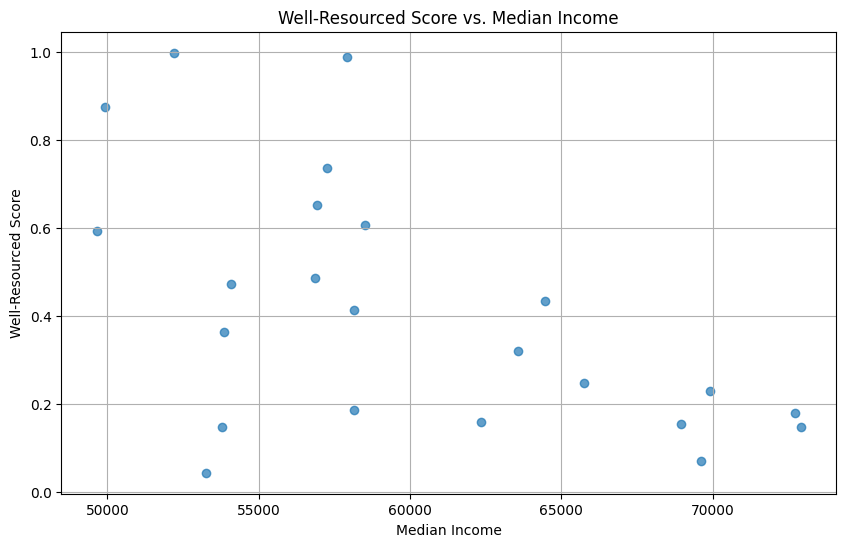

In [19]:
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sqlalchemy import text
final_scores_dict = scores 
scores_series = pd.Series(final_scores_dict, name='well_resourced_score')
scores_df = scores_series.reset_index()
scores_df.columns = ['sa2_name21', 'well_resourced_score']


sql_income_query = """
SELECT
    s.sa2_name21, 
    i.median_income
FROM
    sa2project.income i
JOIN
    sa2project.sa2_boundaries s ON i.sa2_code21 = s.sa2_code21 -- Assuming income uses sa2_code21
WHERE
    s.sa2_name21 IN :sa2_names_list; -- Filter for the SA2s you've scored
"""

# Execute the query for the SA2s present in your scores
# We'll use the SA2 names that are keys in your final_scores_dict
sa2_names_for_correlation = list(final_scores_dict.keys())

try:
    income_df = pd.read_sql_query(text(sql_income_query), conn, params={'sa2_names_list': tuple(sa2_names_for_correlation)})
    print(f"Successfully fetched income data for {len(income_df)} SA2s.")
except Exception as e:
    print(f"Error fetching income data: {e}")
    income_df = pd.DataFrame() # Create empty df to avoid further errors

if not income_df.empty:
    correlation_df = pd.merge(scores_df, income_df, on='sa2_name21', how='inner')

    correlation_df.dropna(subset=['median_income', 'well_resourced_score'], inplace=True)
    print(f"\nData merged for correlation. Number of SA2s after merging and dropping NA: {len(correlation_df)}")

    if len(correlation_df) > 1: 
        correlation_df['median_income'] = pd.to_numeric(correlation_df['median_income'], errors='coerce')
        correlation_df.dropna(subset=['median_income'], inplace=True) # Drop if coercion created NAs

        if len(correlation_df) > 1:
            r_value, p_value = pearsonr(correlation_df['well_resourced_score'], correlation_df['median_income'])

            print(f"\n--- Correlation Analysis Results ---")
            print(f"Pearson Correlation Coefficient (r): {r_value:.4f}")
            print(f"P-value: {p_value:.4f}")

            # Interpretation
            if p_value < 0.05:
                print("The correlation is statistically significant (p < 0.05).")
                if r_value > 0:
                    print("There is a positive linear correlation.")
                elif r_value < 0:
                    print("There is a negative linear correlation.")
                else:
                    print("There is no linear correlation (r is approximately 0).")
            else:
                print("The correlation is not statistically significant (p >= 0.05).")
            print("------------------------------------")

            # --- Step 6: Visualize (Recommended) ---
            plt.figure(figsize=(10, 6))
            plt.scatter(correlation_df['median_income'], correlation_df['well_resourced_score'], alpha=0.7)
            plt.title('Well-Resourced Score vs. Median Income')
            plt.xlabel('Median Income')
            plt.ylabel('Well-Resourced Score')
            plt.grid(True)
            plt.show()
        else:
            print("\nNot enough data points with valid median income to calculate correlation after coercion/dropping NAs.")
    else:
        print("\nNot enough data points to calculate correlation after merging.")
else:
    print("\nIncome data is empty. Cannot proceed with correlation analysis.")

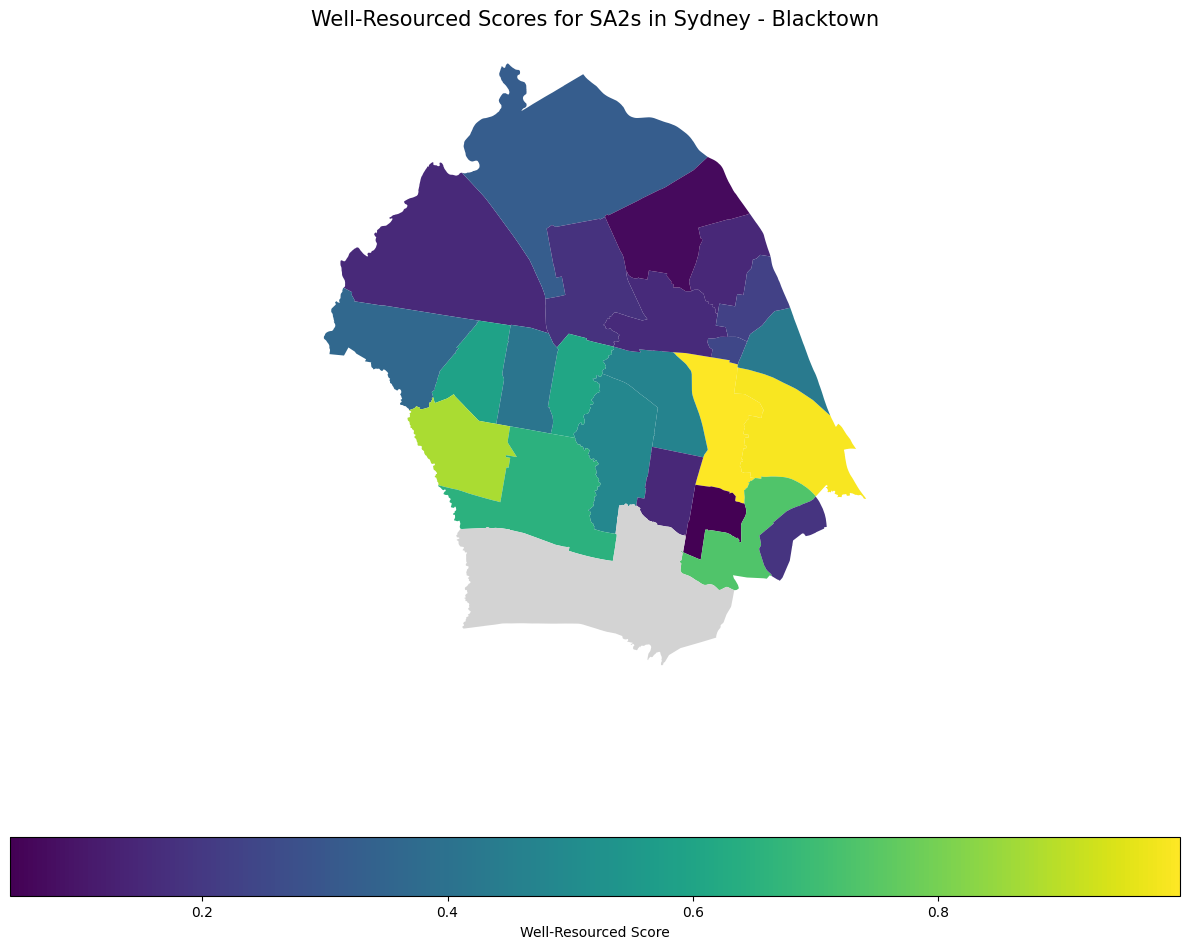


--- Statistics for 'Well-Resourced' Scores in Sydney - Blacktown ---
Average (Mean) Score: 0.413
Median Score:         0.362
(Based on 23 SA2s with scores)


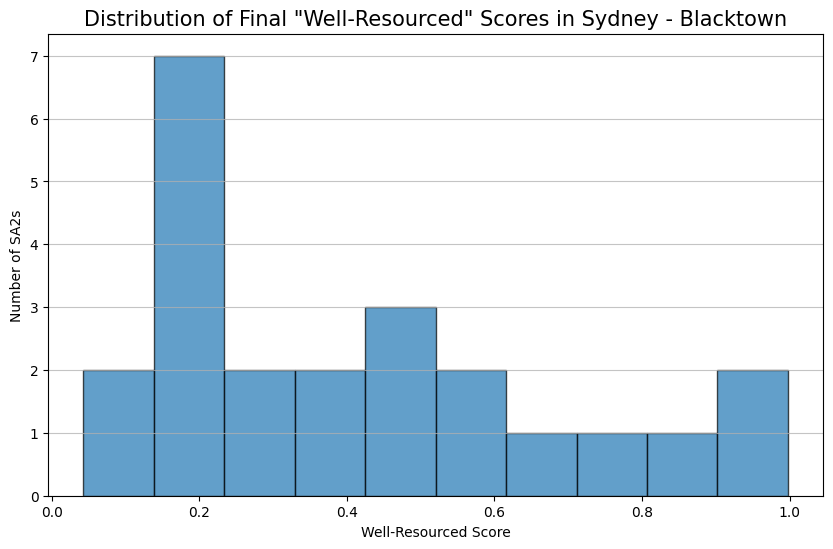

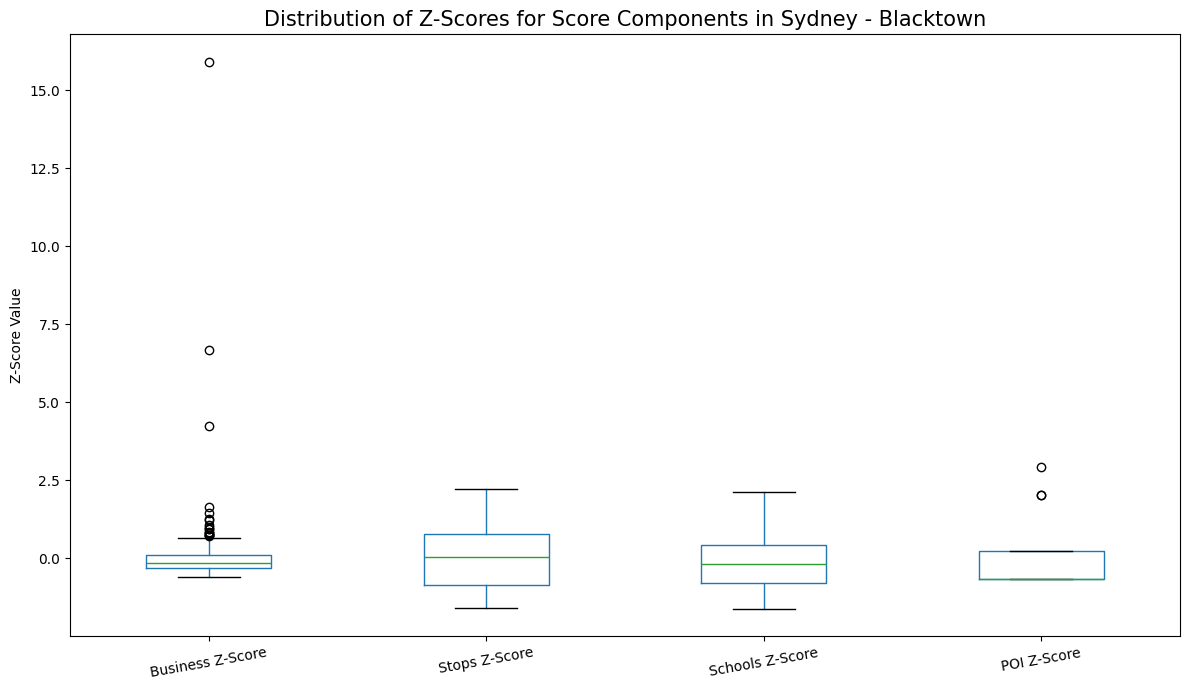

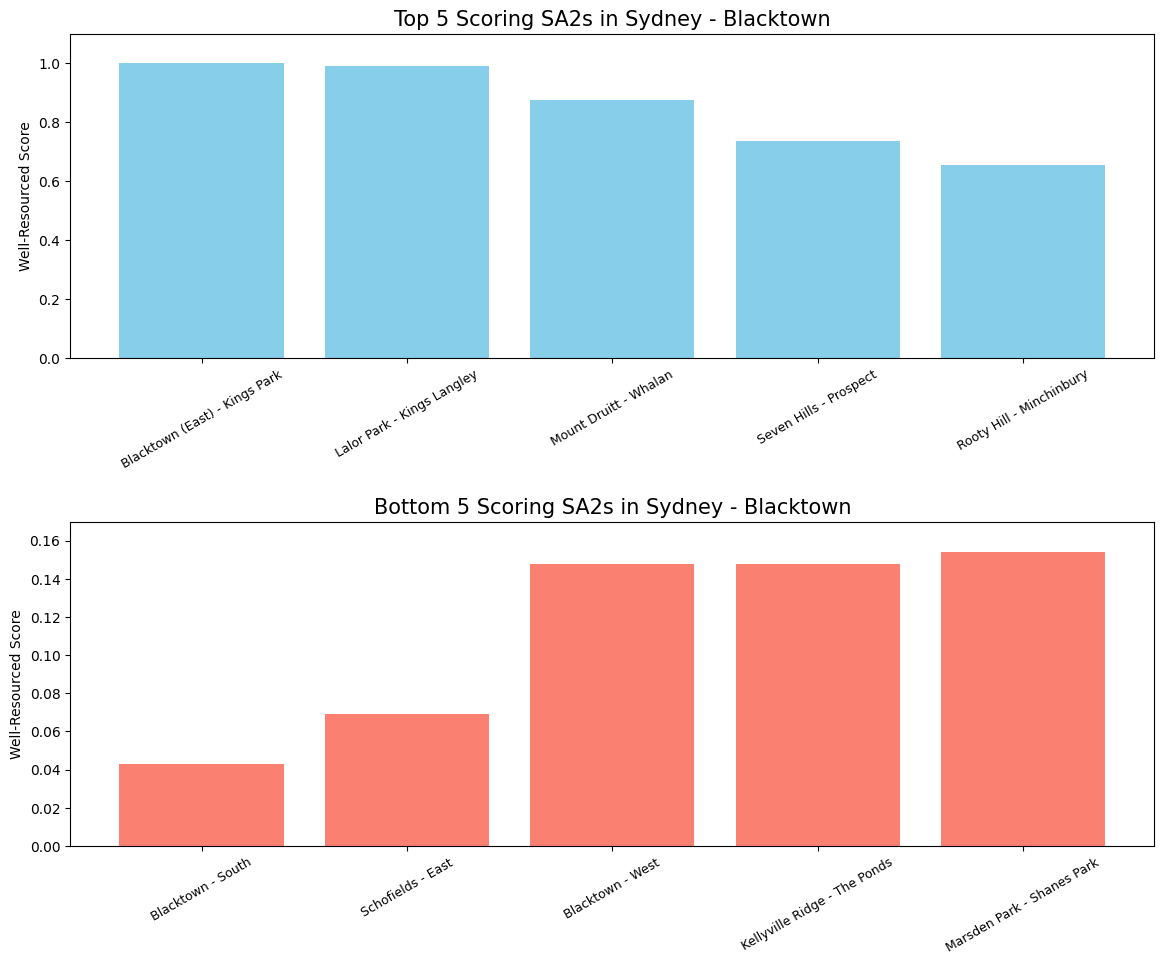

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd # Ensure this is imported

# Assume 'sa2_in_sa4' is your GeoDataFrame for the selected SA4
# Assume 'scores' is your dictionary of final SA2 scores: {'SA2_NAME_1': 0.75, ...}
# Assume 'businesses_z_score', 'stops_z_score', 'schools_z_score', 'POI_z_score' are
# dictionaries or Pandas Series of the z-scores for each component, keyed by SA2 name.

# Convert the scores dictionary to a pandas DataFrame for easier merging and plotting
scores_df = pd.Series(scores, name='well_resourced_score').reset_index()
scores_df.rename(columns={'index': 'sa2_name21'}, inplace=True) # Ensure the SA2 name column matches

# --- 1. Choropleth Map of Final "Well-Resourced" Scores ---

# Merge scores with the SA2 geometries
# Ensure the SA2 name column in sa2_in_sa4 (e.g., 'sa2_name21') matches scores_df
if 'sa2_name21' not in sa2_in_sa4.columns:
    print("Error: 'sa2_name21' column not found in sa2_in_sa4 GeoDataFrame. Please check column names.")
    # Add code here to inspect sa2_in_sa4.columns if needed, e.g., print(sa2_in_sa4.columns)
else:
    sa2_scores_gdf = sa2_in_sa4.merge(scores_df, on='sa2_name21', how='left')

    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    sa2_scores_gdf.plot(column='well_resourced_score',
                        ax=ax,
                        legend=True,
                        cmap='viridis', # You can choose other colormaps like 'plasma', 'coolwarm', etc.
                        missing_kwds={"color": "lightgrey", "label": "Missing/No Score"},
                        legend_kwds={'label': "Well-Resourced Score", 'orientation': "horizontal"})
    ax.set_title(f'Well-Resourced Scores for SA2s in {selected_sa4}', fontsize=15) # Assuming selected_sa4 variable holds your SA4 name
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

valid_scores = scores_df['well_resourced_score'].dropna()

# Calculate the average (mean) score
average_score = valid_scores.mean()

# Calculate the median score
median_score = valid_scores.median()

# Print the results
print(f"\n--- Statistics for 'Well-Resourced' Scores in {selected_sa4} ---")
print(f"Average (Mean) Score: {average_score:.3f}") # Using .3f to format to 3 decimal places
print(f"Median Score:         {median_score:.3f}") # Using .3f to format to 3 decimal places
print(f"(Based on {len(valid_scores)} SA2s with scores)")

plt.figure(figsize=(10, 6))
plt.hist(scores_df['well_resourced_score'].dropna(), bins=10, edgecolor='black', alpha=0.7)
plt.title(f'Distribution of Final "Well-Resourced" Scores in {selected_sa4}', fontsize=15)
plt.xlabel('Well-Resourced Score')
plt.ylabel('Number of SA2s')
plt.grid(axis='y', alpha=0.75)
plt.show()

# b) Box Plots of Individual Z-Scores for Components
# Create a DataFrame for the z-scores
z_scores_data = {
    'Business Z-Score': pd.Series(businesses_z_score), # From cell [d9415bb31aab9c31]
    'Stops Z-Score': pd.Series(stops_z_score),         # From cell [d9415bb31aab9c31]
    'Schools Z-Score': pd.Series(schools_z_score),     # From cell [d9415bb31aab9c31]
    'POI Z-Score': pd.Series(POI_z_score)              # From cell [d9415bb31aab9c31]
}
z_scores_df = pd.DataFrame(z_scores_data)

plt.figure(figsize=(12, 7))
z_scores_df.boxplot(grid=False)
plt.title(f'Distribution of Z-Scores for Score Components in {selected_sa4}', fontsize=15)
plt.ylabel('Z-Score Value')
plt.xticks(rotation=10) # Rotate labels if they overlap
plt.tight_layout()
plt.show()


# --- 3. Bar Chart of Top N and Bottom N Scoring SA2s ---
N = 5 # You can change N to show more or fewer SA2s

# Sort by score
sorted_scores_df = scores_df.sort_values(by='well_resourced_score', ascending=False).dropna()

top_n_df = sorted_scores_df.head(N)
bottom_n_df = sorted_scores_df.tail(N)

# Combine for plotting or plot separately
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False) # sharex=False if SA2 names are long

# Top N
axes[0].bar(top_n_df['sa2_name21'], top_n_df['well_resourced_score'], color='skyblue')
axes[0].set_title(f'Top {N} Scoring SA2s in {selected_sa4}', fontsize=15)
axes[0].set_ylabel('Well-Resourced Score')
axes[0].tick_params(axis='x', rotation=30, labelsize=9) # Rotate x-axis labels for readability
axes[0].set_ylim(bottom=min(0, top_n_df['well_resourced_score'].min() * 0.9), top=top_n_df['well_resourced_score'].max() * 1.1)


# Bottom N (ascending for bar chart readability)
bottom_n_df_sorted = bottom_n_df.sort_values(by='well_resourced_score', ascending=True)
axes[1].bar(bottom_n_df_sorted['sa2_name21'], bottom_n_df_sorted['well_resourced_score'], color='salmon')
axes[1].set_title(f'Bottom {N} Scoring SA2s in {selected_sa4}', fontsize=15)
axes[1].set_ylabel('Well-Resourced Score')
axes[1].tick_params(axis='x', rotation=30, labelsize=9) # Rotate x-axis labels
axes[1].set_ylim(bottom=min(0, bottom_n_df_sorted['well_resourced_score'].min() * 0.9), top=bottom_n_df_sorted['well_resourced_score'].max() * 1.1 if bottom_n_df_sorted['well_resourced_score'].max() > 0 else 0.1)


plt.tight_layout(pad=2.0) 
plt.show()